In [6]:
from sklearn.datasets import fetch_openml
import pandas as pd
# import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False)
data = mnist.data
target = mnist.target.astype(np.uint8)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=42)
X_train = X_train / 255.0  # Normalise pixel values
X_test = X_test / 255.0

In [19]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialise the weights and biases for a neural network using Xavier initialisation.
        """
        self.w1 = np.random.randn(hidden_size, input_size) * np.sqrt(2 / input_size)  
        self.b1 = np.zeros((hidden_size, 1))
        self.w2 = np.random.randn(output_size, hidden_size) * np.sqrt(2 / hidden_size) 
        self.b2 = np.zeros((output_size, 1))

    @staticmethod
    def ReLU(z):
        """
        Compute the ReLU activation function.

        Args:
            z (ndarray): Input array.

        Returns:
            ndarray: Output array where each element is max(z, 0).
        """
        return np.maximum(z, 0)

    @staticmethod
    def ReLU_deriv(z):
        """
        Compute the derivative of the ReLU activation function.

        Args:
            z (ndarray): Input array.

        Returns:
            ndarray: Derivative of ReLU.
        """
        return z > 0

    @staticmethod
    def softmax(z):
        """
        Compute the softmax activation function.

        Args:
            z (ndarray): Input array.

        Returns:
            ndarray: Probability distribution across classes.
        """
        exp_z = np.exp(z - np.max(z))  # subtract max(z) for numerical stability
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    @staticmethod
    def one_hot(y, num_classes):
        """
        Convert labels to one-hot encoding.

        Args:
            y (ndarray): Labels of shape (m,).

        Returns:
            ndarray: One-hot encoded labels of shape (num_classes, m).
        """
        one_hot_y = np.zeros((y.size, num_classes))
        one_hot_y[np.arange(y.size), y] = 1
        return one_hot_y.T

    def forward_prop(self, X):
        """
        Perform forward propagation through the neural network.

        Args:
            X (ndarray): Input data of shape (m, 784).

        Returns:
            tuple: (z1, a1, z2, a2)
                - z1: Weighted input to the first layer.
                - a1: Activation from the first layer.
                - z2: Weighted input to the second layer.
                - a2: Output probabilities from the network.
        """
        z1 = np.dot(self.w1, X.T) + self.b1
        a1 = self.ReLU(z1)
        z2 = np.dot(self.w2, a1) + self.b2
        a2 = self.softmax(z2)
        return z1, a1, z2, a2

    def backward_prop(self, z1, a1, z2, a2, X, y):
        """
        Perform backward propagation to compute gradients.

        Args:
            z1 (ndarray): Weighted input to the first layer.
            a1 (ndarray): Activation from the first layer.
            z2 (ndarray): Weighted input to the second layer.
            a2 (ndarray): Output probabilities.
            X (ndarray): Input data.
            y (ndarray): Ground truth labels.

        Returns:
            tuple: Gradients (dw1, db1, dw2, db2).
        """
        m = X.shape[0]
        one_hot_y = self.one_hot(y, self.w2.shape[0])
        dz2 = a2 - one_hot_y
        dw2 = (1 / m) * np.dot(dz2, a1.T)
        db2 = (1 / m) * np.sum(dz2, axis=1, keepdims=True)
        dz1 = np.dot(self.w2.T, dz2) * self.ReLU_deriv(z1)
        dw1 = (1 / m) * np.dot(dz1, X)
        db1 = (1 / m) * np.sum(dz1, axis=1, keepdims=True)
        return dw1, db1, dw2, db2

    def update_params(self, dw1, db1, dw2, db2, alpha):
        """
        Update the weights and biases using gradient descent.

        Args:
            dw1, db1, dw2, db2 (ndarray): Gradients of weights and biases.
            alpha (float): Learning rate.
        """
        self.w1 -= alpha * dw1
        self.b1 -= alpha * db1
        self.w2 -= alpha * dw2
        self.b2 -= alpha * db2

    def compute_loss(self, a2, y):
        """
        Compute the cross-entropy loss.

        Args:
            a2 (ndarray): Output probabilities.
            y (ndarray): Ground truth labels in one-hot encoding.

        Returns:
            float: Cross-entropy loss.
        """
        m = y.shape[0]
        one_hot_y = self.one_hot(y, a2.shape[0])
        return -np.sum(one_hot_y * np.log(a2)) / m

    def get_predictions(self, a2):
        """
        Get class predictions from output probabilities.

        Args:
            a2 (ndarray): Output probabilities.

        Returns:
            ndarray: Predicted class indices.
        """
        return np.argmax(a2, axis=0)

    def get_accuracy(self, predictions, y):
        """
        Compute the accuracy of predictions.

        Args:
            predictions (ndarray): Predicted class indices.
            y (ndarray): Ground truth labels.

        Returns:
            float: Accuracy in percentage.
        """
        return np.mean(predictions == y) * 100

    def train(self, X_train, y_train, X_test, y_test, alpha, epochs):
        """
        Train the neural network using gradient descent.

        Args:
            X_train (ndarray): Training data.
            y_train (ndarray): Training labels.
            X_test (ndarray): Test data.
            y_test (ndarray): Test labels.
            alpha (float): Learning rate.
            epochs (int): Number of iterations.

        Returns:
            tuple: Training and testing metrics (accuracies and losses).
        """
        training_accuracies = []
        test_accuracies = []
        training_losses = []
        test_losses = []

        for i in range(epochs + 1):
            z1, a1, z2, a2 = self.forward_prop(X_train)
            dw1, db1, dw2, db2 = self.backward_prop(z1, a1, z2, a2, X_train, y_train)
            self.update_params(dw1, db1, dw2, db2, alpha)

            # Training metrics
            train_loss = self.compute_loss(a2, y_train)
            train_accuracy = self.get_accuracy(self.get_predictions(a2), y_train)
            training_accuracies.append(train_accuracy)
            training_losses.append(train_loss)

            # Test metrics
            _, _, _, a2_test = self.forward_prop(X_test)
            test_loss = self.compute_loss(a2_test, y_test)
            test_accuracy = self.get_accuracy(self.get_predictions(a2_test), y_test)
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)

            # Print metrics every 10 epochs
            if i % 200 == 0 or i == epochs:
                print(f"Epoch {i}/{epochs}")
                print(f"    Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
                print(f"    Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")

        return training_accuracies, test_accuracies, training_losses, test_losses


In [20]:
class NeuralNetworkPlots:
    @staticmethod
    def plot_metrics(training_accuracies, test_accuracies, training_losses, test_losses, epochs):
        """
        Plot training and test accuracy and loss over epochs.

        Args:
            training_accuracies (list): Training accuracy values over epochs.
            test_accuracies (list): Test accuracy values over epochs.
            training_losses (list): Training loss values over epochs.
            test_losses (list): Test loss values over epochs.
            epochs (int): Total number of epochs.
        """
        epochs_range = range(epochs + 1)

        plt.figure(figsize=(10, 12))

        # training and test accuracy
        plt.subplot(2, 1, 1)
        plt.plot(epochs_range, training_accuracies, label='Training Accuracy')
        plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
        plt.title('Training and Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # training and test Loss
        plt.subplot(2, 1, 2)
        plt.plot(epochs_range, training_losses, label='Training Loss')
        plt.plot(epochs_range, test_losses, label='Test Loss')
        plt.title('Training and Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    @staticmethod
    def predict(X, model):
        """
        Make predictions using the trained neural network.

        Args:
            X (ndarray): Input data of shape (m, n), where m is the number of examples and n is the number of features.
            model (NeuralNetwork): Trained neural network object.

        Returns:
            ndarray: Predicted labels for the input data.
        """
        _, _, _, a2 = model.forward_prop(X)
        return model.get_predictions(a2)

    @staticmethod
    def test_prediction(index, X_train, y_train, model):
        """
        Visualise a single example from the training set and compare the model's prediction with the true label.

        Args:
            index (int): Index of the example in the training set.
            X_train (ndarray): Training data.
            y_train (ndarray): Training labels.
            model (NeuralNetwork): Trained neural network object.

        Returns:
            None: Displays the image and prints the prediction and true label.
        """
        current_image = X_train[index].reshape((28, 28)) * 255
        prediction = NeuralNetworkPlots.predict(X_train[index:index+1], model)[0]
        label = y_train[index]

        print(f"Prediction: {prediction}")
        print(f"True Label: {label}")

        plt.gray()
        plt.imshow(current_image, interpolation='nearest')
        plt.axis('off')
        plt.show()

    @staticmethod
    def plot_images(images, predictions, labels):
        """
        Plot a grid of 10 images with their predicted and true labels.

        Args:
            images (ndarray): Array of image data of shape (10, 784).
            predictions (ndarray): Model predictions for the images.
            labels (ndarray): True labels for the images.

        Returns:
            None: Displays a plot of images with labels.
        """
        plt.figure(figsize=(10, 5))
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].reshape(28, 28), cmap='gray')
            plt.title(f"Pred: {predictions[i]},\nTrue: {labels[i]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_confusion_matrix(X_test, y_test, model):
        """
        Plot the confusion matrix for the neural network's predictions on the test set.

        Args:
            X_test (ndarray): Test data.
            y_test (ndarray): Ground truth labels for the test data.
            model (NeuralNetwork): Trained neural network object.

        Returns:
            None: Displays the confusion matrix.
        """
        _, _, _, a2 = model.forward_prop(X_test)
        predictions = model.get_predictions(a2)
        cm = confusion_matrix(y_test, predictions)

        plt.figure(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='viridis')
        plt.title('Confusion Matrix')
        plt.show()

In [21]:
alpha=0.01
epochs=1500

nn = NeuralNetwork(input_size=784, hidden_size=10, output_size=10)
training_accuracies, test_accuracies, training_losses, test_losses = nn.train(
    X_train, y_train, X_test, y_test, alpha, epochs
)


Epoch 0/1500
    Training Loss: 2.3287, Accuracy: 11.66%
    Test Loss: 2.3174, Accuracy: 11.90%
Epoch 200/1500
    Training Loss: 1.5067, Accuracy: 52.72%
    Test Loss: 1.5052, Accuracy: 53.08%
Epoch 400/1500
    Training Loss: 1.0005, Accuracy: 76.50%
    Test Loss: 1.0027, Accuracy: 76.33%
Epoch 600/1500
    Training Loss: 0.7555, Accuracy: 81.10%
    Test Loss: 0.7601, Accuracy: 80.81%
Epoch 800/1500
    Training Loss: 0.6335, Accuracy: 83.57%
    Test Loss: 0.6398, Accuracy: 83.21%
Epoch 1000/1500
    Training Loss: 0.5612, Accuracy: 85.18%
    Test Loss: 0.5686, Accuracy: 84.73%
Epoch 1200/1500
    Training Loss: 0.5133, Accuracy: 86.23%
    Test Loss: 0.5217, Accuracy: 85.74%
Epoch 1400/1500
    Training Loss: 0.4793, Accuracy: 86.98%
    Test Loss: 0.4884, Accuracy: 86.56%
Epoch 1500/1500
    Training Loss: 0.4658, Accuracy: 87.31%
    Test Loss: 0.4752, Accuracy: 86.90%


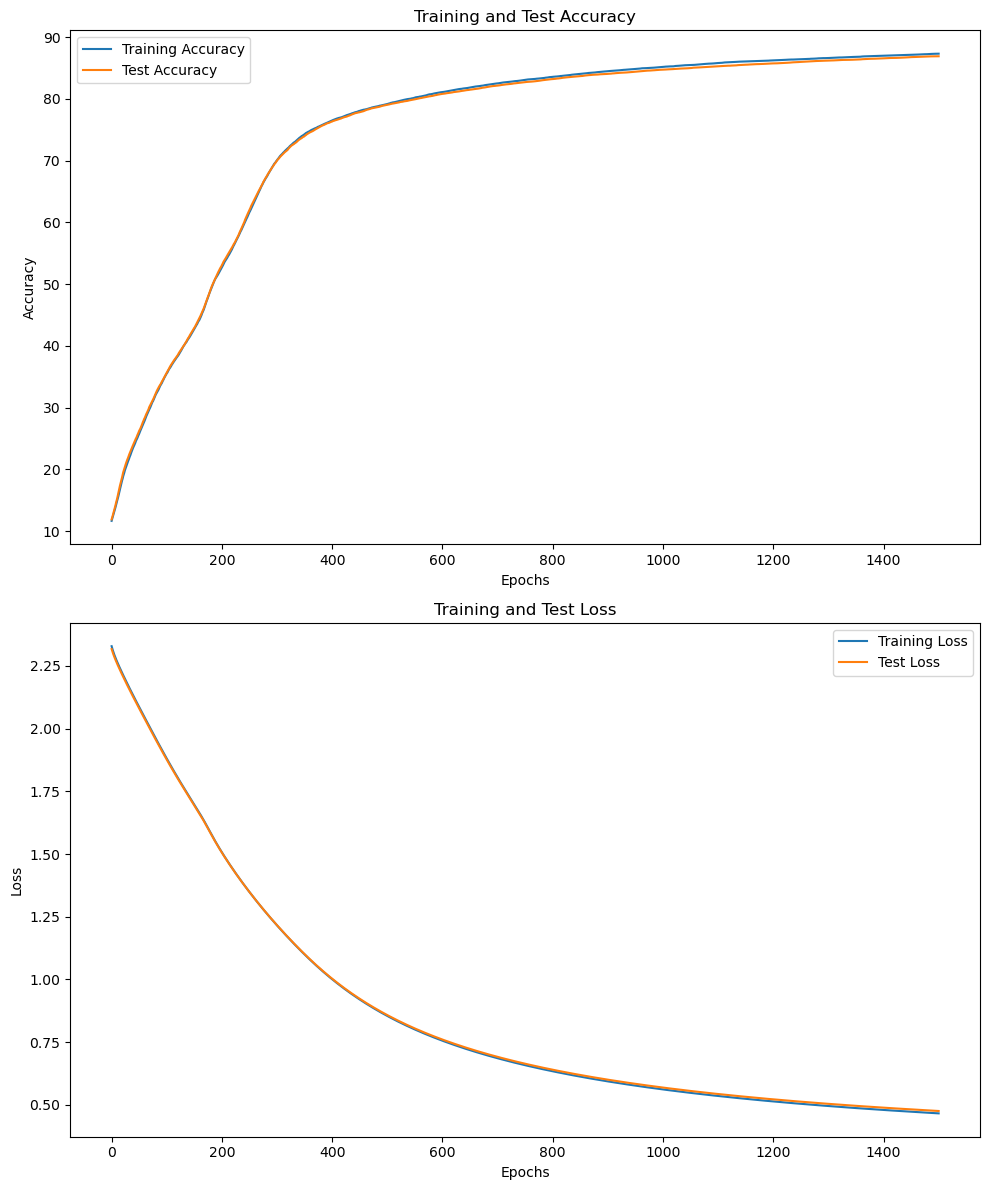

Test Accuracy: 86.89714285714287%


<Figure size 800x600 with 0 Axes>

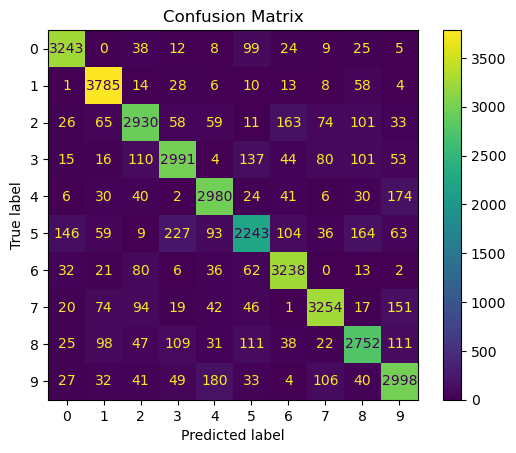

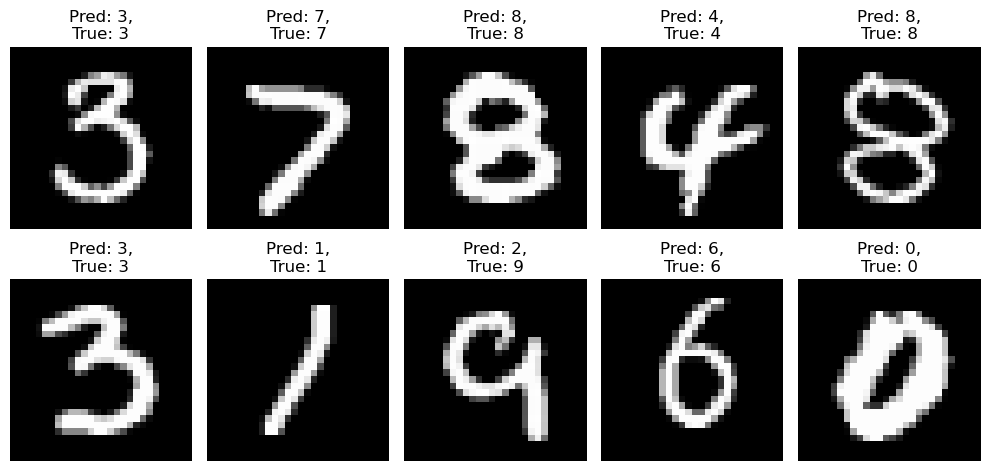

In [22]:
# plotting training and test metrics
NeuralNetworkPlots.plot_metrics(training_accuracies, test_accuracies, training_losses, test_losses, epochs)

# predictions for the test set
test_predictions = NeuralNetworkPlots.predict(X_test, nn)

# calculates test accuracy
accuracy = nn.get_accuracy(test_predictions, y_test)
print(f"Test Accuracy: {accuracy}%")

# plots the confusion matrix
NeuralNetworkPlots.plot_confusion_matrix(X_test, y_test, nn)

random_indices = np.random.choice(len(X_test), size=10, replace=False)
NeuralNetworkPlots.plot_images(
    X_test[random_indices], 
    test_predictions[random_indices], 
    y_test[random_indices]
)
